In [1]:
# ! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

In [2]:
# !pip install ipython-autotime
# %load_ext autotime

In [3]:
import os
# os.chdir('/content/MinesweeperLearning')

In [4]:
import torch
import numpy as np

import src.utils as utils

from torch.utils.data import DataLoader

from src.models.patch_mlp import MineSweeperDataset, PatchMLPModel, Game
from src.models.unet import UnetModel
from src.models.conv import ConvModel
from src.player import Player, ThresholdPlayer

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
rng = np.random.default_rng()

cpu


In [ ]:
data = utils.sample(np.load('data/dataset.npy'), 200_000)

In [7]:
model_type = 'conv'

In [ ]:
if model_type == 'patch_mlp':
    patch_radius = 3
    d = 2*patch_radius+1
    layers= [2**i for i in range(10, 0, -1)]
    name = f'patch_mlp_{d}x{d}_{layers[0]}'
    print(name)

    model = PatchMLPModel(
        patch_radius,
        layers,
        device=device)
    transform = model.transform
    weights = None
    dataset = MineSweeperDataset(data, transform, weights)

In [ ]:
if model_type == 'conv':
    r, c = (16, 30)
    kernel_radius = 1
    layers= [2**i for i in range(8, 0, -1)]
    name = f'conv_{r}x{c}_{layers[0]}'
    print(name)

    model = ConvModel(
        kernel_radius,
        layers,
        device=device)
    transform = model.transform
    weights = ((data == 9) & (data == -1)).view(np.int8)
    dataset = MineSweeperDataset(data, transform, weights)

conv_16x30_32


In [ ]:
if model_type == 'unet':
    r, c, m = (16, 30, 99)
    decoder_shapes = [(128, 16, 30), (256, 8, 15), (512, 4, 7), (1024, 2, 3)]
    name = f'unet_{r}x{c}_{decoder_shapes[0][0]}'
    print(name)

    model = UnetModel(
        map_size=(r, c),
        decoder_shapes=decoder_shapes,
        device=device)
    transform = model.transform
    weights = ((data == 9) & (data == -1)).view(np.int8)
    dataset = MineSweeperDataset(data, transform, weights)

In [11]:
batch_size = 128
training_data, test_data = torch.utils.data.random_split(dataset, (0.95, 0.05))
train_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)
player = ThresholdPlayer(model, 0.01, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

In [12]:
test_games = Game(n = 50)
zeros = test_games.open_zero()

In [13]:
train_loss = []
test_loss = []
win_rate = []

In [ ]:
epochs = 10
stop_if_no_max_after = -1
max_win_rate, argmax_t = 0, 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(model.train(train_dataloader, optimizer))
    player.play(test_games)
    win_rate.append(test_games.win_rate())
    print(win_rate[-1])
    test_games.reset()
    test_games.move(zeros)
    test_loss.append(model.test(test_dataloader))
    if stop_if_no_max_after > 0:
      if win_rate[-1] > max_win_rate:
        model.save(os.path.join('weights', name + '_max.pth'))
        max_win_rate = win_rate[-1]
      if win_rate[-1] > max_win_rate - 0.01:
        argmax_t = t
      elif t - argmax_t >= stop_if_no_max_after:
          break

Epoch 1
-------------------------------
0.0


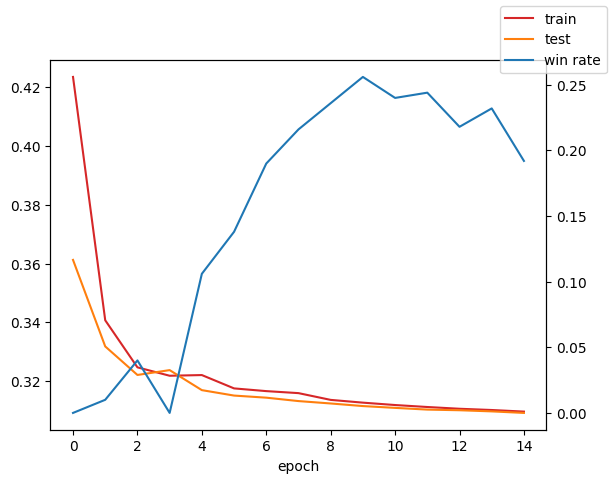

time: 343 ms (started: 2024-10-27 19:39:04 +00:00)


In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [34]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

time: 101 ms (started: 2024-10-27 20:21:30 +00:00)


In [ ]:
model_reference = PatchMLPModel.load('weights/patch_mlp_7x7_1024.pth', device)
player_reference = ThresholdPlayer(model_reference, 0.01, 0.99)
test_player = ThresholdPlayer(model, 0.01, 0.99)

time: 57.5 ms (started: 2024-10-27 19:39:49 +00:00)


In [39]:
games = Game(16, 30, 99, 1000)
z = games.open_zero()
player_reference.play(games)
print(f'player_reference: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')
reference_won = games.won.copy()

player_reference: average score: 0.7955826771653544
	win rate: 0.283
time: 8.75 s (started: 2024-10-27 20:22:57 +00:00)


In [40]:
games.reset()
games.move(z)
test_player.play(games)
print(f'test_player: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')

test_player: average score: 0.7635091863517061
	win rate: 0.284
time: 13.1 s (started: 2024-10-27 20:23:15 +00:00)


In [56]:
reinforce_iterations = 1
epochs = 1
base_size, reinforce_size = 10_000, 10_000
losing_move_weight = 2
for i in range(reinforce_iterations):
  base = utils.sample(dataset, base_size)
  games = Game(16, 30, rng.normal(99, 30, reinforce_size).astype(int).clip(40, 160), reinforce_size)
  games.open_zero()
  player.play(games)
  data = np.concatenate([base, games.as_dataset()])
  weights = np.concatenate([np.ones_like(base), np.abs(games.losing_moves())*losing_move_weight])
  train_data = MineSweeperDataset(data, transform, weights)
  train_dataloader = DataLoader(train_data, batch_size, num_workers=4, pin_memory=True, shuffle=True)
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss.append(model.train(train_dataloader, optimizer))
      player.play(test_games)
      win_rate.append(test_games.win_rate())
      print(win_rate[-1])
      test_games.reset()
      test_games.move(zeros)
      test_loss.append(model.test(test_dataloader))

Epoch 1
-------------------------------
0.306
time: 3min 35s (started: 2024-10-27 20:35:13 +00:00)


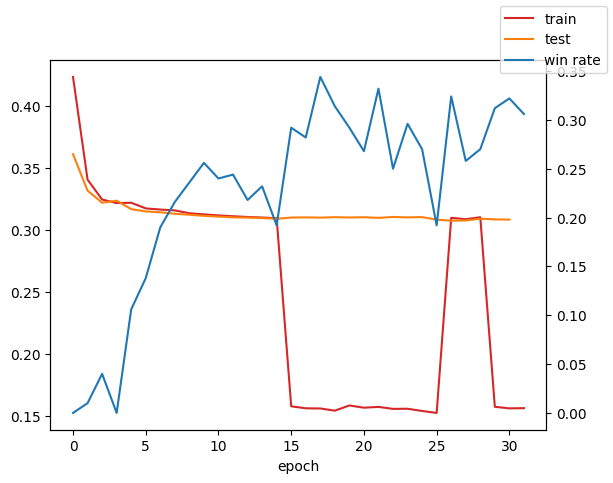

time: 289 ms (started: 2024-10-27 20:38:49 +00:00)


In [57]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [55]:
model.save(os.path.join('weights', name + '_reinforced.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '_reinforced.opt'))

time: 103 ms (started: 2024-10-27 20:34:30 +00:00)


In [62]:
games = Game(16, 30, 99, 1000)
z = games.open_zero()
player_reference.play(games)
print(f'player_reference: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')
reference_won = games.won.copy()

player_reference: average score: 0.7900918635170605
	win rate: 0.282
time: 8.58 s (started: 2024-10-27 20:39:51 +00:00)


In [63]:
games.reset()
games.move(z)
test_player.play(games)
print(f'test_player: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')

test_player: average score: 0.8288136482939633
	win rate: 0.267
time: 16.6 s (started: 2024-10-27 20:39:59 +00:00)
